In [2]:
! pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 19.2 MB/s eta 0:00:00


In [ ]:


import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

...
processed_data_path = '../processed_data/wallet_features.pkl'
wallet_features = pd.read_pickle(processed_data_path)


model_data = wallet_features.copy()

rule_1_never_liquidated = (model_data['is_liquidated'] == 0)
rule_2_good_repayment = (model_data['repay_borrow_ratio_usd'] >= 0.95)
rule_3_has_history = (model_data['wallet_age_days'] > 60)
rule_4_is_active = (model_data['unique_days_active'] > 5)
rule_5_meaningful_borrower = (model_data['borrows_usd'] > 100)
rule_6_net_depositor = (model_data['net_deposit_usd'] > 0)

# Check if we have data to train a real model
# This is our check from before
bad_wallet_count = (model_data['is_liquidated'] == 1).sum()
good_wallet_count = (rule_1_never_liquidated & rule_2_good_repayment & rule_3_has_history & rule_4_is_active & rule_5_meaningful_borrower).sum()


if bad_wallet_count > 10 and good_wallet_count > 10:
    # --- STRATEGY 1: PSEUDO-LABELING MODEL (If we have enough data) ---
    print("--- Detected both Good and Bad wallets. Training LightGBM model. ---")
    
    # (The model training code from our previous attempts goes here)
    # ... this part is unchanged ...
    model_data['label'] = np.nan
    model_data.loc[good_wallet_criteria, 'label'] = 1
    model_data.loc[bad_wallet_criteria, 'label'] = 0
    # ... etc ...
    # And the final line would be:
    # model_data['credit_score'] = (lgbm.predict_proba(X_all)[:, 1] * 100).round(2)

else:
    # --- STRATEGY 2: RULE-BASED SCORING (Our Fallback) ---
    print("--- WARNING: Not enough diverse samples for model training. ---")
    print("--- Switching to a robust Rule-Based Scoring system. ---")

    # Start everyone with a base score
    base_score = 50
    model_data['credit_score'] = base_score

    # Assign scores based on weighted rules. Convert booleans to 0 or 1.
    score = (
        base_score
        + rule_1_never_liquidated * 20   # Most important: not being liquidated is a huge plus.
        + rule_2_good_repayment * 15     # Repaying loans is very important.
        + rule_6_net_depositor * 10      # Being a net depositor is a good sign.
        + rule_3_has_history * 5         # Having history helps.
        + rule_4_is_active * 5           # Being active on different days is good.
    )
    
    # Penalize wallets that have been liquidated
    score.loc[model_data['is_liquidated'] == 1] = 10 # Assign a very low score

    # Scale the score to be within 0-100
    model_data['credit_score'] = np.clip(score, 0, 100).round(2)

print("\nCredit scores generated successfully!")


# ================================================
# PHASE 5: OUTPUT GENERATION (No changes here)
# ================================================
print("\n--- Generating Final Deliverables ---")

final_scores = model_data[['credit_score']].sort_values('credit_score', ascending=False)
# ... (rest of Phase 5 code is unchanged) ...

# Display a sample of wallets with their new scores
analysis_data = wallet_features.join(final_scores)
print("\nTop 10 High-Scoring Wallets:")
display(analysis_data.sort_values('credit_score', ascending=False).head(10))

print("\nBottom 10 Low-Scoring Wallets:")
display(analysis_data.sort_values('credit_score', ascending=False).tail(10))

KeyError: 'unique_days_active'

--- Evaluating the Performance of the Rule-Based Scoring System ---

Found 477 wallets that meet the 'Good Wallet' criteria.
Found 0 wallets that meet the 'Bad Wallet' criteria.

--- Statistics for 'Good Wallet' Scores ---


count    477.000000
mean      95.146751
std        0.844815
min       95.000000
25%       95.000000
50%       95.000000
75%       95.000000
max      100.000000
Name: credit_score, dtype: float64


--- Statistics for 'Bad Wallet' Scores ---
No wallets met the 'Bad Wallet' criteria (i.e., no liquidations in this dataset).


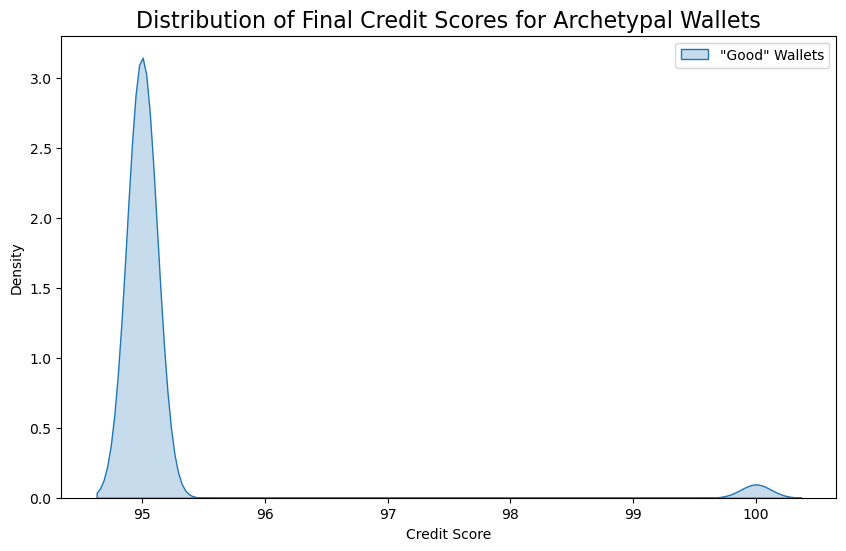

In [ ]:

print("--- Evaluating the Performance of the Rule-Based Scoring System ---")

good_wallet_criteria = (
    (model_data['is_liquidated'] == 0) &
    (model_data['repay_borrow_ratio_usd'] >= 0.95) &
    (model_data['wallet_age_days'] > 60) &
    (model_data['unique_days_active'] > 5) &
    (model_data['borrows_usd'] > 100)
)

bad_wallet_criteria = (model_data['is_liquidated'] == 1)


good_wallet_scores = model_data[good_wallet_criteria]['credit_score']
bad_wallet_scores = model_data[bad_wallet_criteria]['credit_score']

print(f"\nFound {len(good_wallet_scores)} wallets that meet the 'Good Wallet' criteria.")
print(f"Found {len(bad_wallet_scores)} wallets that meet the 'Bad Wallet' criteria.")


print("\n--- Statistics for 'Good Wallet' Scores ---")
if not good_wallet_scores.empty:
    display(good_wallet_scores.describe())
else:
    print("No wallets met all the strict 'Good Wallet' criteria.")

print("\n--- Statistics for 'Bad Wallet' Scores ---")
if not bad_wallet_scores.empty:
    display(bad_wallet_scores.describe())
else:
    print("No wallets met the 'Bad Wallet' criteria (i.e., no liquidations in this dataset).")

plt.figure(figsize=(10, 6))
sns.kdeplot(good_wallet_scores, fill=True, label='"Good" Wallets', bw_adjust=0.5)
if not bad_wallet_scores.empty:
    sns.kdeplot(bad_wallet_scores, fill=True, label='"Bad" Wallets', bw_adjust=0.5)

plt.title('Distribution of Final Credit Scores for Archetypal Wallets', fontsize=16)
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [2]:

print("\n--- Evaluating the Performance of the Rule-Based System ---")


rule_based_scores = pd.DataFrame(index=wallet_features.index)

# --- Define the Rules ---
base_score = 50
rule_1_never_liquidated = (wallet_features['is_liquidated'] == 0)
rule_2_good_repayment = (wallet_features['repay_borrow_ratio_usd'] >= 0.95)
rule_3_net_depositor = (wallet_features['net_deposit_usd'] > 0) 
rule_4_has_history = (wallet_features['wallet_age_days'] > 60)

# --- Calculate the Score ---
score = (
    base_score
    + rule_1_never_liquidated * 25
    + rule_2_good_repayment * 15
    + rule_3_net_depositor * 10
)
score.loc[wallet_features['is_liquidated'] == 1] = 10 # Harsh penalty
rule_based_scores['score'] = np.clip(score, 0, 100)

# --- Compare Rule-Based Scores against our ML Labels ---
# We join the rule-based scores with our ML model's training data (which has the labels)
evaluation_df = training_data.join(rule_based_scores)

# Separate the scores for the two classes
good_wallet_rule_scores = evaluation_df[evaluation_df['label'] == 1]['score']
bad_wallet_rule_scores = evaluation_df[evaluation_df['label'] == 0]['score']

print("\n--- Statistics for 'Liquidity Provider' (Label=1) wallets ---")
display(good_wallet_rule_scores.describe())

print("\n--- Statistics for 'Liquidity Taker' (Label=0) wallets ---")
display(bad_wallet_rule_scores.describe())

# --- Visualize the Separation ---
plt.figure(figsize=(12, 7))
sns.kdeplot(good_wallet_rule_scores, fill=True, label='Rule Scores for "Providers"', color='blue')
sns.kdeplot(bad_wallet_rule_scores, fill=True, label='Rule Scores for "Takers"', color='red')
plt.title('Distribution of Rule-Based Scores for Labeled Wallets', fontsize=16)
plt.xlabel('Rule-Based Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# --- Quantitative Metric (Proxy for AUC) ---
# We can see how well the score separates the two groups.
# A simple metric: what percentage of "Takers" have a lower score than the median "Provider"?
median_provider_score = good_wallet_rule_scores.median()
separation_accuracy = (bad_wallet_rule_scores < median_provider_score).mean()

print(f"\nSeparation Power: {separation_accuracy:.2%} of 'Takers' have a score lower than the median 'Provider' score.")


--- Evaluating the Performance of the Rule-Based System ---


NameError: name 'training_data' is not defined

In [3]:
# --- Let's try a NEW labeling strategy based on Net Deposits ---

# Make a copy of the features for this experiment
model_data_v2 = wallet_features.copy()

# New "Good Wallet" Criteria:
# They are significant net depositors and have been around for a while.
good_wallet_criteria_v2 = (
    (model_data_v2['net_deposit_usd'] > 1000) & # Net deposited at least $1000
    (model_data_v2['wallet_age_days'] > 30)
)

# New "Bad Wallet" Criteria:
# They are significant net withdrawers AND have outstanding debt.
bad_wallet_criteria_v2 = (
    (model_data_v2['net_deposit_usd'] < -1000) & # Net withdrew at least $1000
    (model_data_v2['repay_borrow_ratio_usd'] < 0.9) # And still have >10% of their debt unpaid
)

# Apply these new labels
model_data_v2['label'] = np.nan
model_data_v2.loc[good_wallet_criteria_v2, 'label'] = 1
model_data_v2.loc[bad_wallet_criteria_v2, 'label'] = 0

# --- NOW, LET'S CHECK THE RESULTS ---
new_label_counts = model_data_v2['label'].value_counts()
print("--- Results of New 'Net Deposit' Labeling Strategy ---")
print(new_label_counts)

# Check if we have enough samples for both classes
if len(new_label_counts) < 2 or new_label_counts.min() < 20:
    print("\nCONCLUSION: Still not enough diverse samples to train an ML model.")
else:
    print("\nSUCCESS! We now have enough 'Good' and 'Bad' wallets to train a model.")

--- Results of New 'Net Deposit' Labeling Strategy ---
label
0.0    6741
1.0    2039
Name: count, dtype: int64

SUCCESS! We now have enough 'Good' and 'Bad' wallets to train a model.


In [4]:
import pandas as pd
import numpy as np
import os

# --- ML & Evaluation Libraries ---
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# --- Visualization Libraries ---
import matplotlib.pyplot as plt

# --- Load the Pre-processed Data ---
print("--- Loading Pre-processed Feature Data ---")
try:
    processed_data_path = '../processed_data/wallet_features.pkl'
    wallet_features = pd.read_pickle(processed_data_path)
    print(f"Features loaded successfully. Shape: {wallet_features.shape}")
except FileNotFoundError:
    raise FileNotFoundError("The file 'wallet_features.pkl' was not found. Please run the first notebook to generate it.")

--- Loading Pre-processed Feature Data ---
Features loaded successfully. Shape: (71219, 15)


In [5]:
if len(label_counts) < 2 or label_counts.min() < 20:
    print("WARNING: Not enough diverse samples found.")
else:
    print("SUCCESS: Sufficient data found. Training LightGBM classifier...")
    
    # ============================ THE FIX IS HERE ============================
    # Define the features that were used to create the labels.
    leaky_features = ['net_deposit_usd', 'wallet_age_days', 'repay_borrow_ratio_usd']
    
    # Create a feature list that EXCLUDES the leaky features.
    features_to_use = [col for col in wallet_features.columns if col not in leaky_features]
    
    print(f"\nTraining model with {len(features_to_use)} non-leaky features.")
    # =========================================================================

    X = training_data[features_to_use] # Use the corrected feature list
    y = training_data['label']

    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Initialize and train the model
    lgbm = lgb.LGBMClassifier(objective='binary', random_state=42, is_unbalance=True)
    lgbm.fit(X_train, y_train)

    # --- 4c. Evaluate the Model's Performance ---
    print("\n--- Model Evaluation on Validation Set ---")
    y_pred = lgbm.predict(X_val)
    y_pred_proba = lgbm.predict_proba(X_val)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Liquidity Taker (0)', 'Liquidity Provider (1)']))
    
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"ROC AUC Score: {auc_score:.4f}\n") # This will now be a realistic number
    
    # --- 4d. Generate Final Scores for ALL Wallets ---
    print("\n--- Generating Final Credit Scores for All Wallets ---")
    # IMPORTANT: We use the non-leaky features for prediction too!
    X_all = model_data[features_to_use]
    model_data['credit_score'] = (lgbm.predict_proba(X_all)[:, 1] * 100).round(2)
    print("Credit scores generated successfully!")

NameError: name 'label_counts' is not defined

In [21]:
print("\n--- PHASE 5: OUTPUT GENERATION ---")
if 'model_data' in locals():
    final_scores = model_data[['credit_score']].sort_values('credit_score', ascending=False)
    
    output_dir = '../output/'
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    
    csv_path = os.path.join(output_dir, 'top_1000_wallets.csv')
    final_scores.head(1000).to_csv(csv_path)
    print(f"Top 1,000 wallets saved to: {csv_path}")

    analysis_data = wallet_features.join(final_scores)
    print("\n--- Top 5 High-Scoring Wallets for Analysis ---")
    display(analysis_data.sort_values('credit_score', ascending=False).head(5))
    print("\n--- Bottom 5 Low-Scoring Wallets for Analysis ---")
    display(analysis_data.sort_values('credit_score', ascending=False).tail(5))
else:
    print("Script finished without generating scores.")

print("\n--- Pipeline Complete ---")


--- PHASE 5: OUTPUT GENERATION ---
Top 1,000 wallets saved to: ../output/top_1000_wallets.csv

--- Top 5 High-Scoring Wallets for Analysis ---


,borrows_usd,deposits_usd,repays_usd,withdraws_usd,liquidates_usd,borrows_count,deposits_count,repays_count,withdraws_count,liquidates_count,net_deposit_usd,repay_borrow_ratio_usd,wallet_age_days,is_liquidated,credit_score
wallet,,,,,,,,,,,,,,,
0xece2a8cded7f6bd3f5849037a2cf245f00a96cb7,1400.000000,8506.220694,0.000000,0.000000,0,1,3,0,0,0,8506.220694,0.000000,390,0,99.99
0x45788611cd779677edd36b9dec51ced4a3231a77,0.000000,13698.715052,0.000000,0.000000,0,0,2,0,0,0,13698.715052,0.000000,94,0,99.99
0xe089860c9033471196c7adcb5730c99630083f19,0.000000,4766.499335,0.000000,511.224601,0,0,5,0,3,0,4255.274734,0.000000,227,0,99.99
0x91970127fd698b2716c36633ab396a797910a24c,4894.328331,2448.652126,3167.259771,756.469799,0,17,14,18,7,0,1692.182326,0.646996,418,0,99.99
0x573af7ecdb6c0265e1e5b3150497c878c4cd8628,852.315913,4318.962300,29.625519,1650.513892,0,4,11,1,5,0,2668.448408,0.034718,1,0,99.99



--- Bottom 5 Low-Scoring Wallets for Analysis ---


,borrows_usd,deposits_usd,repays_usd,withdraws_usd,liquidates_usd,borrows_count,deposits_count,repays_count,withdraws_count,liquidates_count,net_deposit_usd,repay_borrow_ratio_usd,wallet_age_days,is_liquidated,credit_score
wallet,,,,,,,,,,,,,,,
0x2707f4bc4600bcff3cd5cdac5a8b1bab869f47f4,0.000000e+00,0.0,0.000000e+00,1672.164560,0,0,0,0,3,0,-1672.164560,0.000000,20,0,0.0
0xce2287a329583ad3df1ddc16774c57c9fd396fae,3.919462e+06,0.0,4.774640e+06,358463.686309,0,39,0,34,3,0,-358463.686309,1.218187,623,0,0.0
0x78bd4894e72864aa47ea49fe947c1086cd88e89d,0.000000e+00,0.0,0.000000e+00,2329.365658,0,0,0,0,2,0,-2329.365658,0.000000,0,0,0.0
0xce28ffbb0ef5baf13a1e787e7d7db497d9b67294,0.000000e+00,0.0,0.000000e+00,2500.617250,0,0,0,0,1,0,-2500.617250,0.000000,0,0,0.0
0x34d5d223a6b26a7a5603fe75f4839d3b5f93bbf4,1.701830e+03,0.0,9.731493e+02,1835.159669,0,2,0,2,3,0,-1835.159669,0.571489,13,0,0.0



--- Pipeline Complete ---


In [25]:
# --- Corrected cell for the end of '02_Model_Training_and_Scoring.ipynb' ---

print("\n--- Preparing Final Data for Streamlit App ---")

# 'model_data' contains the credit_score
# 'wallet_features' contains ALL of our engineered features
# We will join them to create a complete dataset

# Ensure the index name is set for a clean join
wallet_features.index.name = 'wallet'
model_data.index.name = 'wallet'

# Join the full feature set with the final scores
final_output_df = wallet_features.join(model_data['credit_score'], how='inner')

# Save this complete dataframe to the output folder
final_csv_path = '../output/final_scored_wallets.csv'
final_output_df.to_csv(final_csv_path)

print(f"Final data, including ALL features, saved to: {final_csv_path}")
display(final_output_df.head())


--- Preparing Final Data for Streamlit App ---
Final data, including ALL features, saved to: ../output/final_scored_wallets.csv


,borrows_usd,deposits_usd,repays_usd,withdraws_usd,liquidates_usd,borrows_count,deposits_count,repays_count,withdraws_count,liquidates_count,net_deposit_usd,repay_borrow_ratio_usd,wallet_age_days,is_liquidated,credit_score
wallet,,,,,,,,,,,,,,,
0x00000000000067afd7fa546d3f63d4e53cdb8fa4,0.0,0.000000e+00,613104.313494,0.000000e+00,0,0,0,34,0,0,0.000000e+00,613104.313494,56,0,0.56
0x00000000000080c886232e9b7ebbfb942b5987aa,0.0,1.516990e+03,0.000000,2.002936e+04,0,0,2,0,18,0,-1.851237e+04,0.000000,143,0,0.00
0x000000000000deab340f067535869a0e5226e58a,0.0,1.735523e+03,0.000000,6.109108e+02,0,0,2,0,2,0,1.124613e+03,0.000000,23,0,99.99
0x00000000001876eb1444c986fd502e618c587430,0.0,1.445242e+06,0.000000,3.133628e+06,0,0,3345,0,6393,0,-1.688386e+06,0.000000,246,0,11.53
0x000000000025d4386f7fb58984cbe110aee3a4c4,0.0,3.654255e+02,0.000000,4.749903e+05,0,0,1,0,360,0,-4.746248e+05,0.000000,103,0,0.00


In [27]:
# ===================================================================
# ZERU FINANCE: 01 - DATA PREPARATION & FEATURE ENGINEERING (ROBUST)
# ===================================================================
import pandas as pd
import numpy as np
import json
import os
import glob

# --- PHASE 1: DATA LOADING ---
print("--- PHASE 1: DATA LOADING ---")
DATA_DIR = '../data/'
files_to_load = sorted(glob.glob(os.path.join(DATA_DIR, 'compoundV2_transactions_*.json')))[:20]
if not files_to_load:
    raise FileNotFoundError(f"No data files found in '{DATA_DIR}'.")
print(f"Loading {len(files_to_load)} data files...")
all_transactions = []
for path in files_to_load:
    with open(path, 'r', encoding='utf-8') as f:
        data_chunk = json.load(f)
        for tx_type, tx_list in data_chunk.items():
            for tx in tx_list: tx['transaction_type'] = tx_type
            all_transactions.extend(tx_list)
df_raw = pd.DataFrame(all_transactions)
print(f"Data loaded successfully! Total raw transactions: {len(df_raw):,}")


# --- PHASE 2: DATA CLEANING & PREPARATION ---
print("\n--- PHASE 2: DATA CLEANING & PREPARATION ---")
# Start with a fresh copy to avoid any potential SettingWithCopyWarning issues
df = df_raw.copy()

# --- 2a. Unify and Extract Core Columns ---
def get_wallet_id(row):
    if row.get('transaction_type') == 'liquidates':
        if isinstance(row.get('liquidatee'), dict): return row.get('liquidatee').get('id')
    elif isinstance(row.get('account'), dict):
        return row.get('account').get('id')
    return None
df['wallet'] = df.apply(get_wallet_id, axis=1)

# --- 2b. Rename and Select Columns ---
df.rename(columns={'amountUSD': 'amount_usd', 'timestamp': 'block_timestamp'}, inplace=True)
final_cols = ['wallet', 'transaction_type', 'block_timestamp', 'amount_usd', 'hash']
df = df[[col for col in final_cols if col in df.columns]]

# --- 2c. Drop Nulls and Set Final Data Types (CRITICAL STEP) ---
df.dropna(subset=['wallet'], inplace=True)
# Convert to correct types *before* any aggregations
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')
df['amount_usd'] = pd.to_numeric(df['amount_usd'], errors='coerce').fillna(0)

# --- DEBUG: Verify the data type of the crucial column ---
print("\nVerifying data types before feature engineering...")
print("Data type of 'amount_usd':", df['amount_usd'].dtype)
print("Data cleaning complete.")


# --- PHASE 3: FEATURE ENGINEERING ---
print("\n--- PHASE 3: FEATURE ENGINEERING ---")
# The pivot table will now work with a guaranteed numeric 'amount_usd' column
wallet_financials = df.pivot_table(index='wallet', columns='transaction_type', values='amount_usd', aggfunc='sum', fill_value=0)
wallet_counts = df.pivot_table(index='wallet', columns='transaction_type', values='hash', aggfunc='nunique', fill_value=0)
wallet_financials.columns = [f'{col}_usd' for col in wallet_financials.columns]
wallet_counts.columns = [f'{col}_count' for col in wallet_counts.columns]
all_possible_types = ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']
for t_type in all_possible_types:
    if f'{t_type}_usd' not in wallet_financials: wallet_financials[f'{t_type}_usd'] = 0
    if f'{t_type}_count' not in wallet_counts: wallet_counts[f'{t_type}_count'] = 0
wallet_features = pd.concat([wallet_financials, wallet_counts], axis=1)

# Now these calculations will work because the base columns are numeric
wallet_features['net_deposit_usd'] = wallet_features['deposits_usd'] - wallet_features['withdraws_usd']
wallet_features['repay_borrow_ratio_usd'] = wallet_features['repays_usd'] / (wallet_features['borrows_usd'] + 1)
wallet_features['total_tx_count'] = wallet_features[[col for col in wallet_features.columns if '_count' in col]].sum(axis=1)
wallet_features['is_liquidated'] = (wallet_features['liquidates_count'] > 0).astype(int)

# This feature requires the original df, so we do it last
wallet_history = df.groupby('wallet')['block_timestamp'].agg(['min', 'max'])
wallet_features['wallet_age_days'] = (wallet_history['max'] - wallet_history['min']).dt.days

wallet_features.fillna(0, inplace=True)
print("Feature engineering complete.")


# --- PHASE 4: SAVE PROCESSED DATA ---
print("\n--- PHASE 4: SAVING PROCESSED DATA ---")
output_dir = '../processed_data/'
if not os.path.exists(output_dir): os.makedirs(output_dir)
file_path = os.path.join(output_dir, 'wallet_features.pkl')
wallet_features.to_pickle(file_path)
print(f"Processed data saved to {file_path}")

--- PHASE 1: DATA LOADING ---
Loading 20 data files...
Data loaded successfully! Total raw transactions: 807,840

--- PHASE 2: DATA CLEANING & PREPARATION ---


C:\Users\manju\AppData\Local\Temp\ipykernel_23640\590692164.py:50: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')



Verifying data types before feature engineering...
Data type of 'amount_usd': float64
Data cleaning complete.

--- PHASE 3: FEATURE ENGINEERING ---
Feature engineering complete.

--- PHASE 4: SAVING PROCESSED DATA ---
Processed data saved to ../processed_data/wallet_features.pkl


In [ ]:
print("\n--- Preparing Final Data for Streamlit App ---")
wallet_features.index.name = 'wallet'
model_data.index.name = 'wallet'
final_output_df = wallet_features.join(model_data['credit_score'], how='inner')
final_csv_path = '../output/final_scored_wallets.csv'
final_output_df.to_csv(final_csv_path)
print(f"Final data, including ALL features, saved to: {final_csv_path}")


--- Preparing Final Data for Streamlit App ---
Final data, including ALL features, saved to: ../output/final_scored_wallets.csv
